<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_79).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Motorizacion Turismos)](#Analisis-por-grupo-de-indicadores-(-motorizacion))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Motorizacion Turismos)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Index_Turisme']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2628 entries, 4380 to 7007
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   2628 non-null   int64  
 1   Trimestre             2628 non-null   int64  
 2   Mes                   2628 non-null   int64  
 3   Codi_Districte        2628 non-null   int64  
 4   Nom_Districte         2628 non-null   object 
 5   Codi_Barri            2628 non-null   int64  
 6   Nom_Barri             2628 non-null   object 
 7   Compraventa_Unitario  2628 non-null   float64
 8   Index_Turisme         2628 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 205.3+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Index_Turisme
Fecha,,,,,,,,,
2019-01-01,2019,1,1,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-02-01,2019,1,2,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-03-01,2019,1,3,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-04-01,2019,2,4,1,Ciutat Vella,1,el Raval,3838.4,122.718571
2019-05-01,2019,2,5,1,Ciutat Vella,1,el Raval,3838.4,122.718571


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-01-01,2242.453846,280.495356
2019-02-01,2242.453846,280.495356
2019-03-01,2242.453846,280.495356
2019-04-01,2145.500000,280.495356
2019-05-01,2145.500000,280.495356


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2019-01-01 to 2021-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  36 non-null     float64
 1   Index_Turisme         36 non-null     float64
dtypes: float64(2)
memory usage: 864.0 bytes


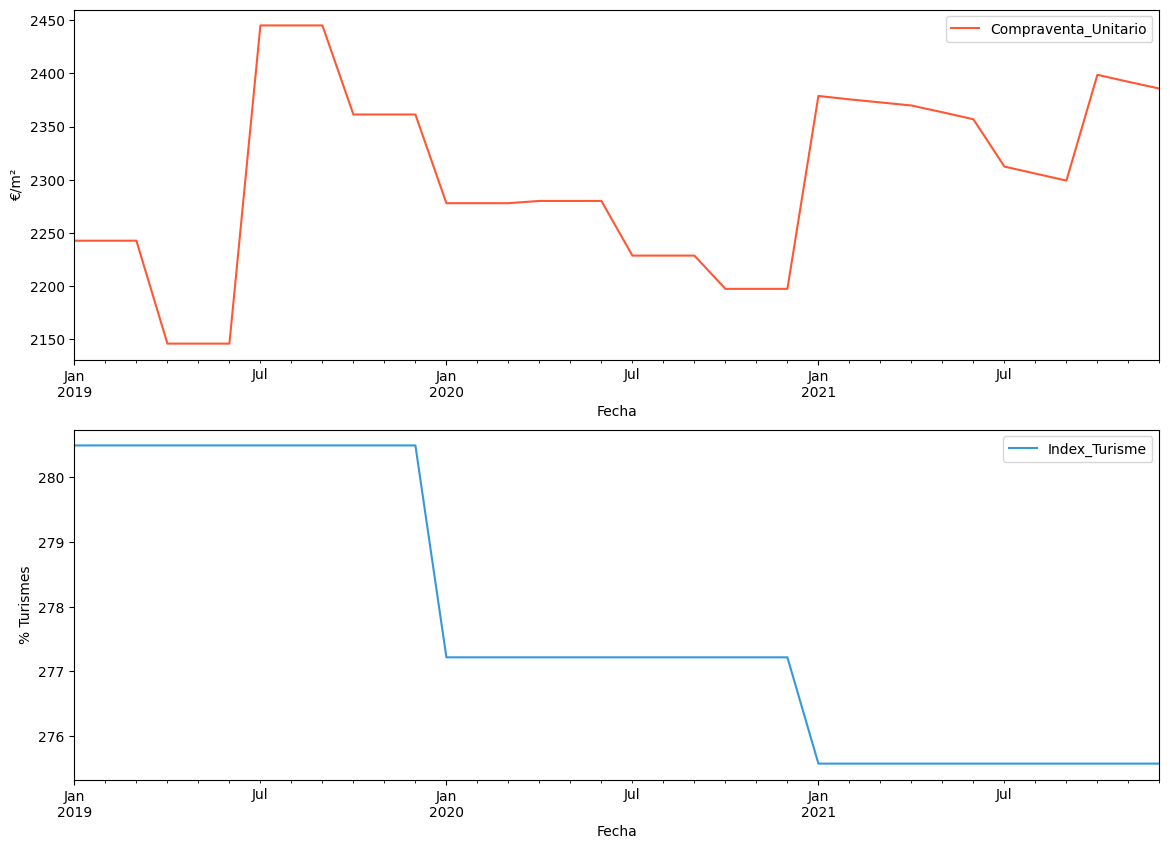

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Turismes' ]
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Index_Turisme
Compraventa_Unitario,1.00000,-0.19876
Index_Turisme,-0.19876,1.00000


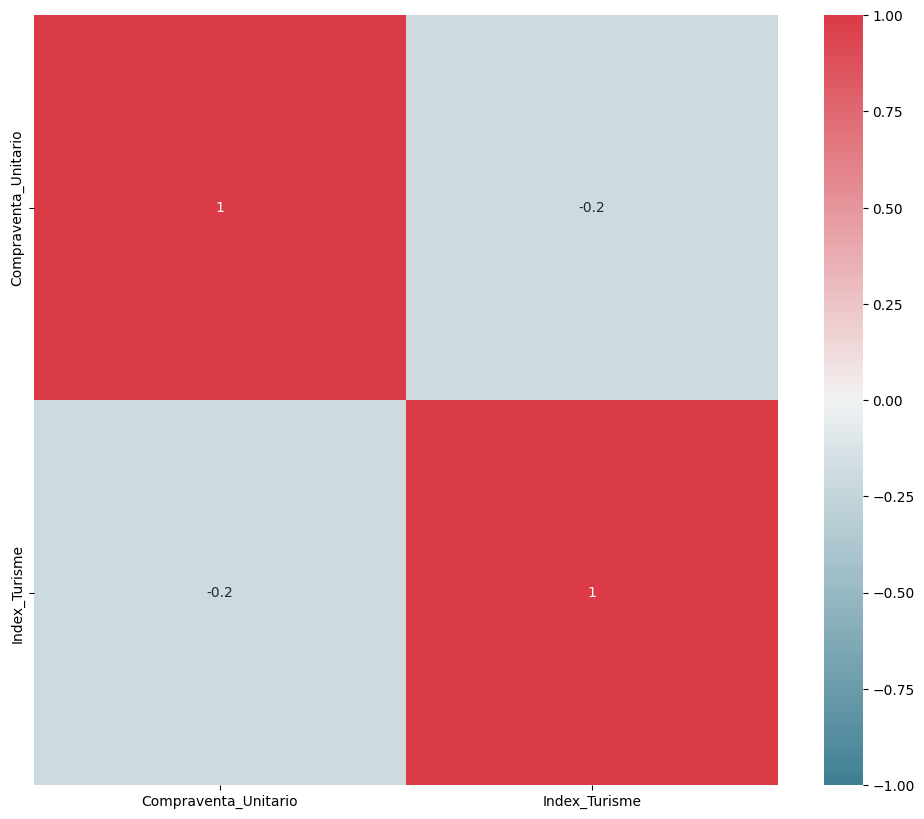

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" e "Index_Turisme" es de -0.19876, lo que sugiere una correlación negativa débil entre estas dos variables en tus datos.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [46]:
fecha_division = '2021-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(30, 2) (6, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [47]:
import statsmodels.tsa.stattools as sts

In [48]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.184481
Serie de tiempo Index_Turisme
p-value: 0.826668


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [49]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-02-01,0.000000,0.0
2019-03-01,0.000000,0.0
2019-04-01,-96.953846,0.0
2019-05-01,0.000000,0.0
2019-06-01,0.000000,0.0


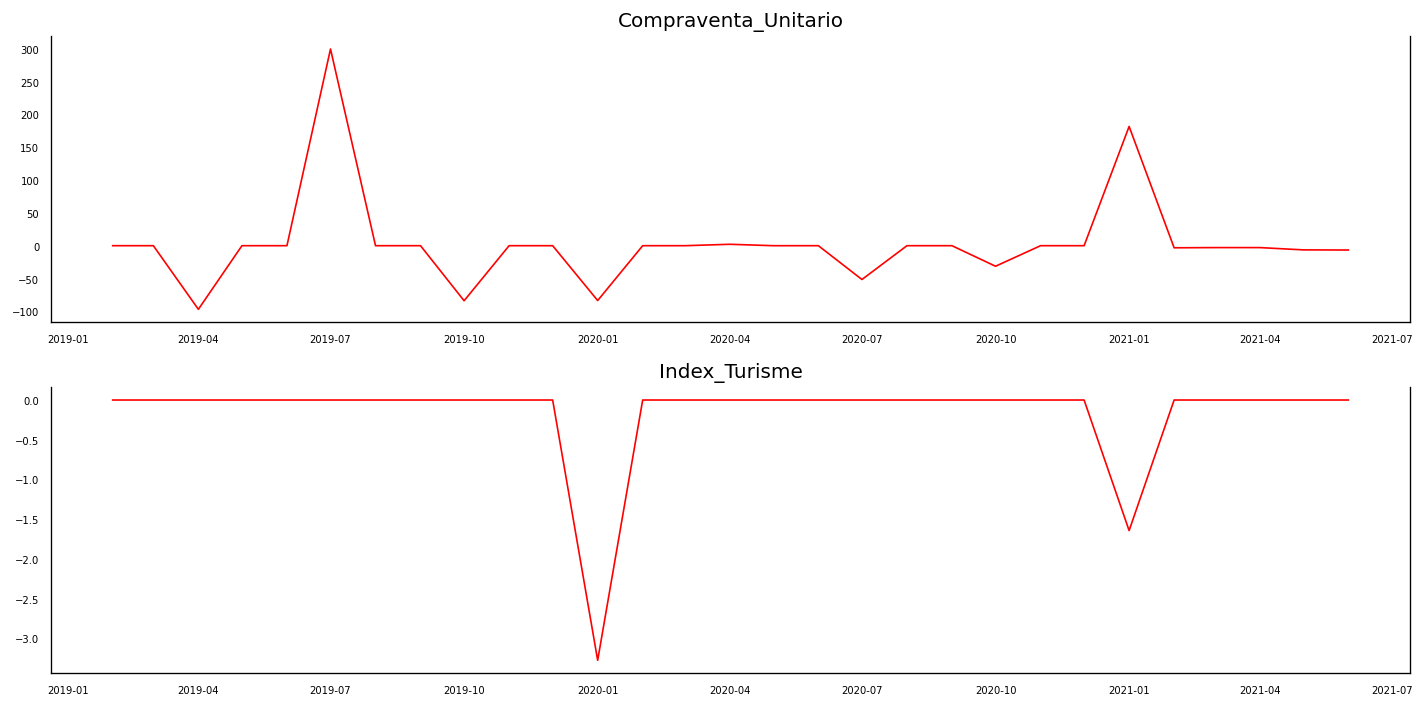

In [50]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [51]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000012
Serie de tiempo transformada Variable Index_Turisme
p-value: 0.000002


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

In [83]:
from statsmodels.tsa.api import VAR

In [84]:
model = VAR(X_train_transformed)

#### Seleccionando el orden del modelo

In [85]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,8.963,9.063,7810.,8.982
1,8.761,9.060,6412.,8.820
2,8.777,9.274,6622.,8.874
3,9.039,9.736,8966.,9.175
4,9.350,10.25,1.321e+04,9.525
5,8.368,9.464,5663.,8.582
6,7.370,8.665,2622.,7.623
7,7.250,8.744,3436.,7.542
8,3.683*,5.376*,201.9*,4.014*


El orden óptimo del modelo VAR, según los criterios AIC, BIC, FPE y HQIC, es 3, ya que tiene el valor más bajo en estos criterios. Esto sugiere que un modelo VAR con un orden de 3 sería el más apropiado para estos datos según estas métricas de evaluación. Es importante considerar otros factores y realizar análisis adicionales para confirmar la selección del orden del modelo VAR.

#### Ajustando el modelo

In [87]:
res = model.fit(maxlags=3)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     12:35:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.2161
Nobs:                     25.0000    HQIC:                   9.72285
Log likelihood:          -176.116    FPE:                    14246.4
AIC:                      9.53353    Det(Omega_mle):         8695.32
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           1.752318        19.739490            0.089           0.929
L1.Compraventa_Unitario        -0.579916         0.213580           -2.715           0.007
L1.In

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Index_Turisme" es de .016547, lo que sugiere una correlación positiva muy debil entre los residuos de estas dos variables en los datos.

In [89]:
X_train.columns

Index(['Compraventa_Unitario', 'Index_Turisme'], dtype='object')

###### Causalidad de Granger

In [90]:
grangercaus=res.test_causality(['Index_Turisme'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.2657,2.866,0.850,"(3, 36)"


In [91]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Index_Turisme'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.03051,2.866,0.993,"(3, 36)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [92]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=3
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Index_Turisme_x
Compraventa_Unitario_y,1.0000,0.9884
Index_Turisme_y,0.6994,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [93]:
residuals=res.resid

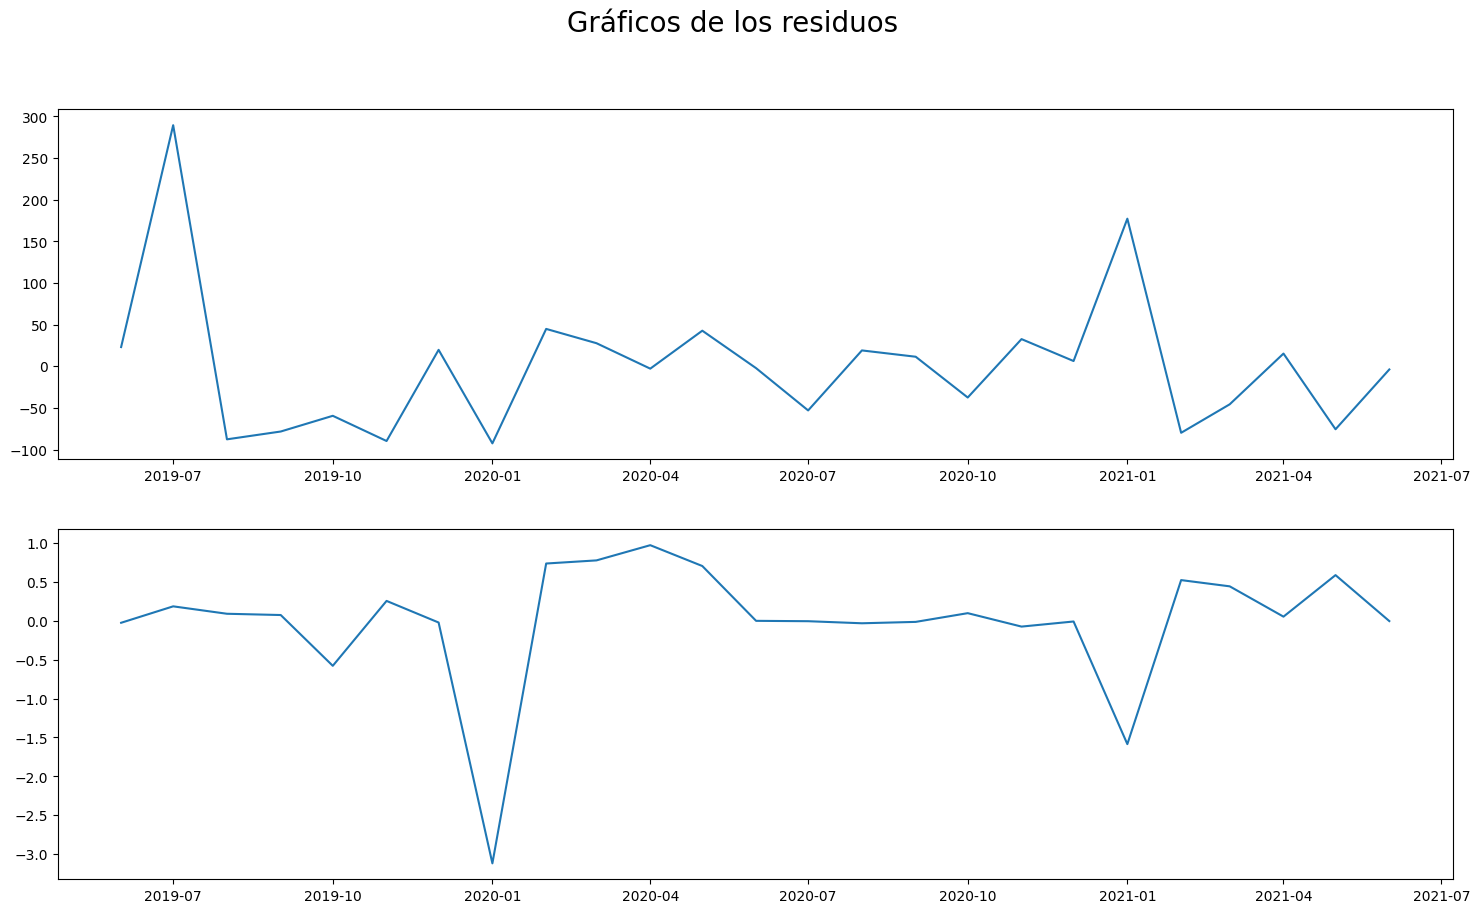

In [94]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [95]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[4.926683510291715e-06, 2.5396877278592336e-05]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


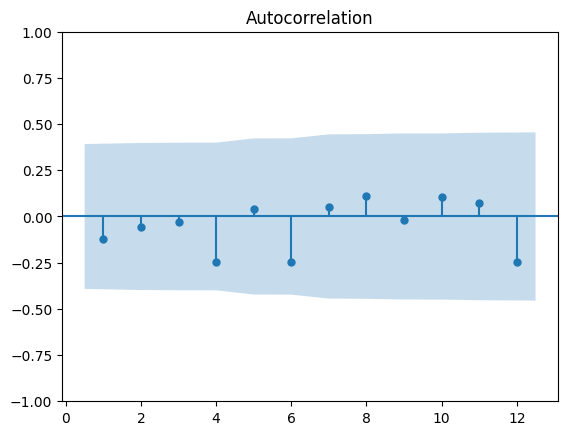

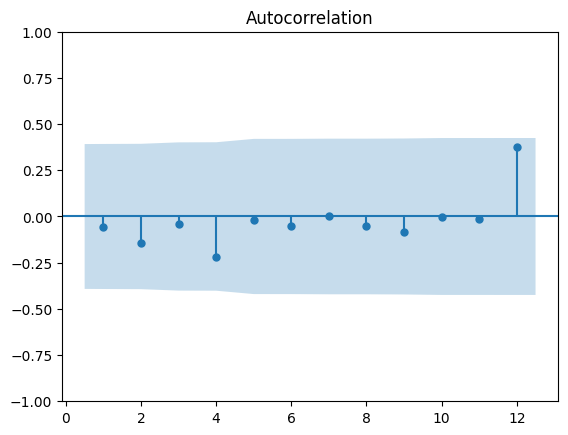

In [96]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


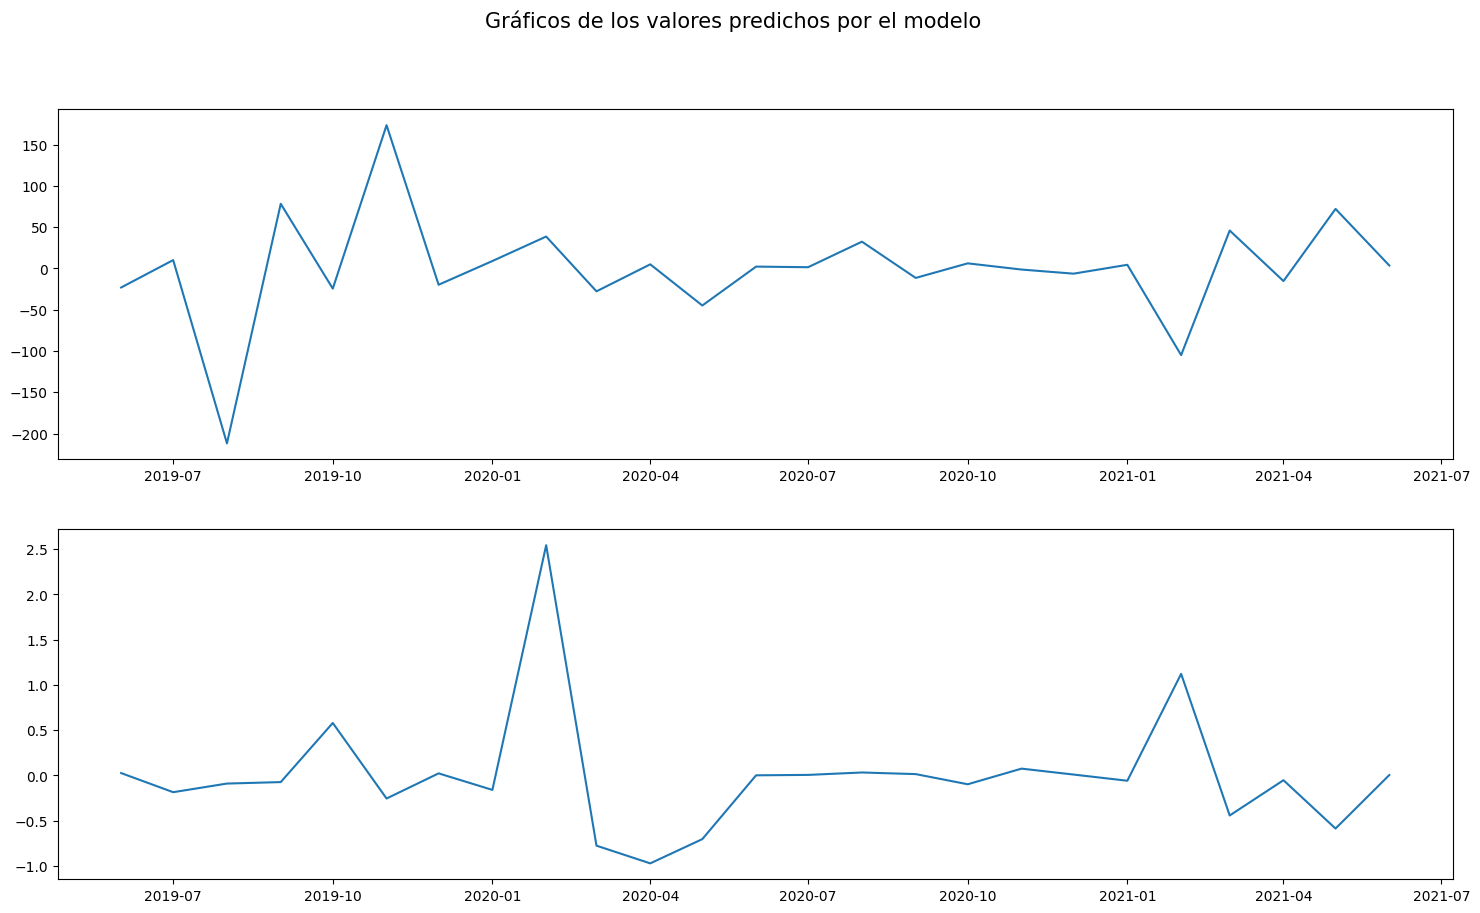

In [97]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [98]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 3
Predicciones:


,Compraventa_Unitario_pred,Index_Turisme_pred
Fecha,,
2021-07-01,3.008127,0.005562
2021-08-01,1.469110,-0.007076
2021-09-01,0.036854,0.000958
2021-10-01,0.024190,0.005534
2021-11-01,1.102481,0.000994
2021-12-01,1.054501,-0.002017


<Figure size 1200x1000 with 0 Axes>

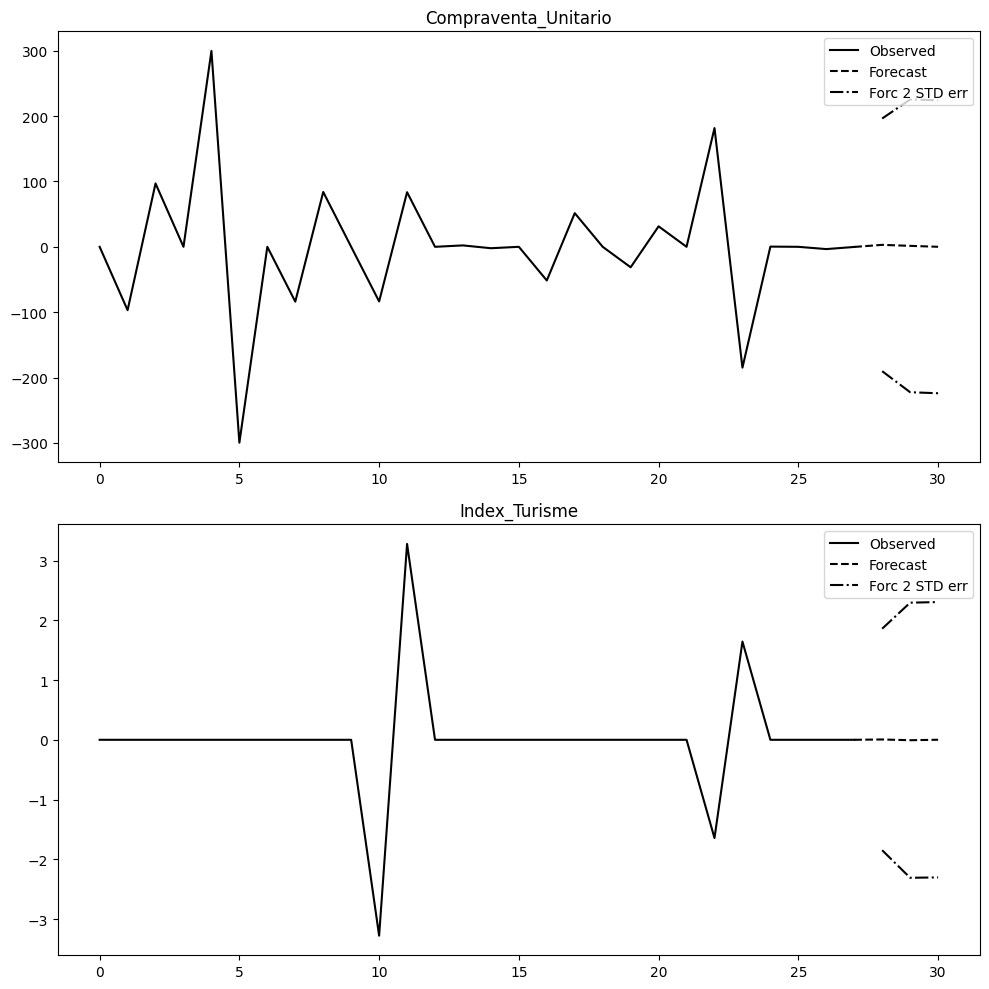

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [100]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [101]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Index_Turisme
Fecha,,
2021-07-01,2359.850847,275.579071
2021-08-01,2361.319957,275.571995
2021-09-01,2361.356811,275.572953
2021-10-01,2361.381001,275.578486
2021-11-01,2362.483482,275.579481
2021-12-01,2363.537982,275.577464


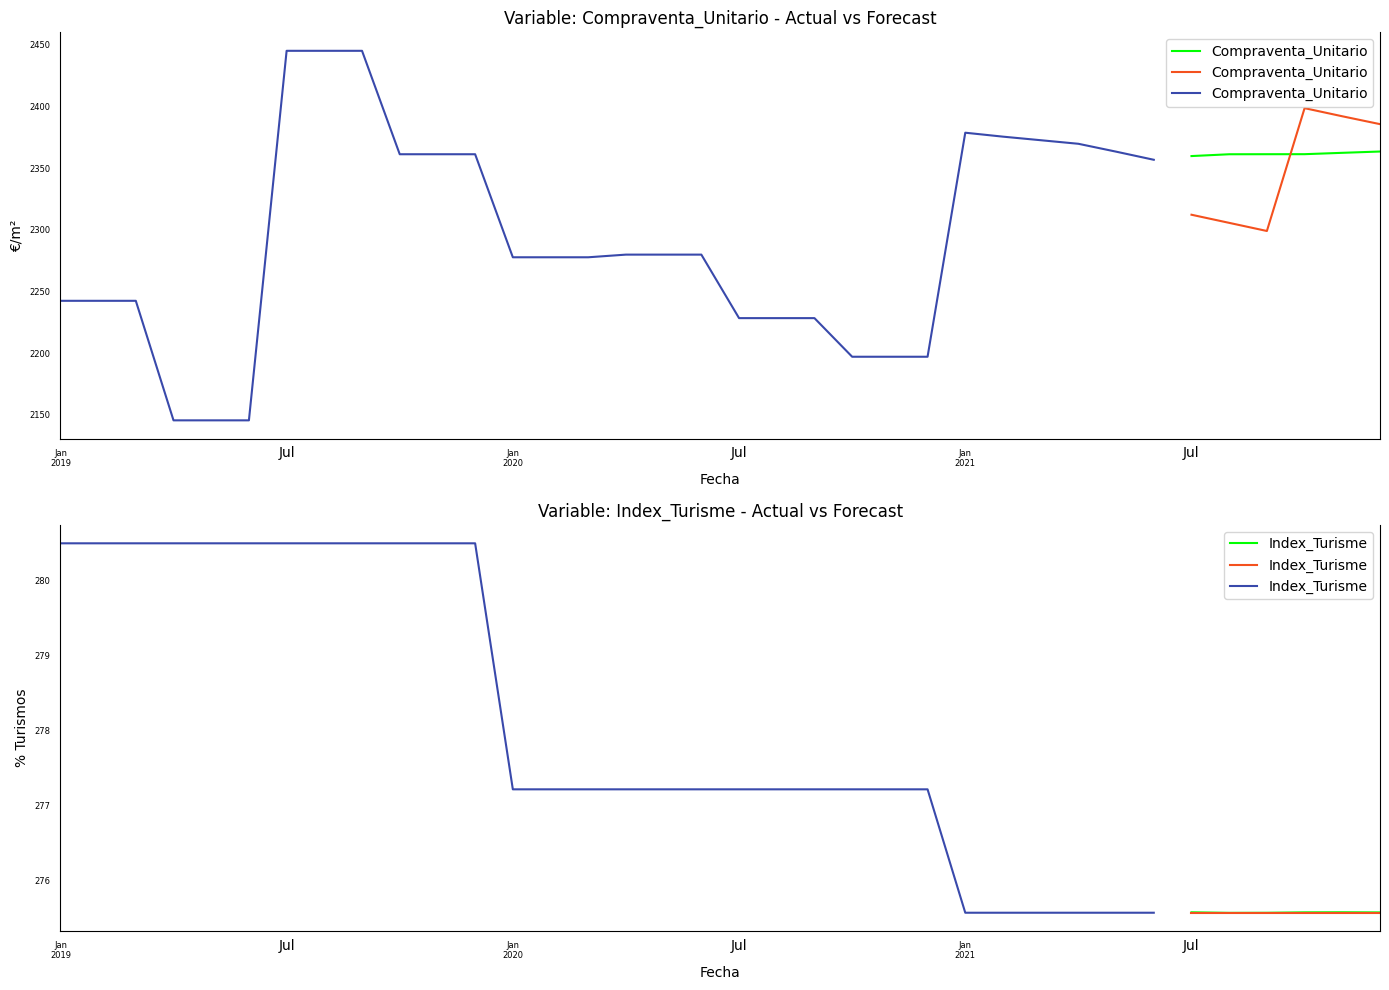

In [102]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Turismos']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [103]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [104]:
for i in ['Compraventa_Unitario','Index_Turisme']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 2000.6908627589373
MAE is : 42.447003615196
RMSE is : 44.72908296353657
MAPE is : 1.817693899140169
R2 is : -0.0530622720473668

Evaluation metric for Index_Turisme
Evaluation metric results:-
MSE is : 1.826702240792488e-05
MAE is : 0.0037559453294117398
RMSE is : 0.00427399373044988
MAPE is : 0.0013629558729733797
R2 is : 0.0



Los resultados de las métricas de evaluación indican que el modelo tiene un rendimiento aceptable para la variable "Compraventa_Unitario", con un MAPE bajo y un R2 cercano a cero, lo que sugiere que el modelo no se ajusta bien a los datos. Para la variable "Index_Turisme", el modelo muestra un rendimiento mucho mejor, con un MAPE y un RMSE muy bajos, lo que indica un buen ajuste del modelo a los datos. Sin embargo, el R2 es cero, lo que sugiere que el modelo no explica la variabilidad de la variable dependiente. En resumen, el modelo tiene un rendimiento moderado para "Compraventa_Unitario" pero un rendimiento sólido para "Index_Turisme".

In [105]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 21.225379780262706
Root mean squared error: 31.62823802416094


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [106]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [108]:
fecha_division = '2021-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(30, 2) (6, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [109]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.184481
Serie de tiempo Index_Turisme
p-value: 0.826668


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [110]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-02-01,0.000000,0.0
2019-03-01,0.000000,0.0
2019-04-01,-96.953846,0.0
2019-05-01,0.000000,0.0
2019-06-01,0.000000,0.0


In [111]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000012
Serie de tiempo transformada Variable Index_Turisme
p-value: 0.000002


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [112]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [113]:
cointegration_test(X_train_transformed[['Compraventa_Unitario','Index_Turisme']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  46.3      > 12.3212   =>   True
Index_Turisme >  2.56      > 4.1296    =>   False


Para la variable "Compraventa_Unitario": El valor del estadístico de prueba es 46.3, que supera significativamente el valor crítico de 12.3212 para un nivel de significancia del 95%. Esto indica que existe una relación de causalidad significativa entre "Compraventa_Unitario" y "Index_Turisme".

Para la variable "Index_Turisme": El valor del estadístico de prueba es 2.56, que es menor que el valor crítico de 4.1296 para un nivel de significancia del 95%. Por lo tanto, no hay suficiente evidencia para rechazar la hipótesis nula de que "Index_Turisme" no causa Granger a "Compraventa_Unitario".

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [114]:
import pmdarima as pm

In [115]:

pq = []
for name in ['Compraventa_Unitario', 'Index_Turisme']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=332.285, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=334.285, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=334.285, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=336.284, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=334.198, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.370 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : Index_Turisme
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.010, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=64.010, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=64.010, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=66.010, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=62.150, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0

#####Seleccion del modelo

In [116]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [117]:
pq

[(0, 0, 0), (0, 0, 0)]

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMAX, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.

Por lo que para estos datos, no es posible entrenar un modelo VARMAX

##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y indice de motorizacion de turismos, tenemos que:

- Se ha comprobado que las variables tienen una baja correlacion inversa.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del segundo orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede causar las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- No se a podido aplicar el modelo VARMAX, por la nula autocorrelacion de los datos.

Con los datos obtenidos unicamente se ha podido entrenar un modelo VAR.

